# **CV Course Project: Assignment - Image Recognition**

##**Group:**

Alumno 1: San Millan Rodrigues, Nadine (n.srodrigues@alumnos.upm.es)

Alumno 2: Sukhorukova, Anastasia (anastasia.s@alumnos.upm.es)

Alumno 3: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)

Course: Computer Vision (CV) - 2025/26

Institution: Polytechnic University of Madrid (UPM)

Date: January 2026

##**Goals**
The goals of the assignment are:

Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.
Follow the link below to download the classification data set “xview_recognition”: https://drive.upm.es/s/2DDPE2zHw5dbM3G

#**0 Setup and Data Loading**
##**0.1 Install and Import Required Libraries**

In [1]:
!pip install tensorflow numpy rasterio scikit-learn matplotlib keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.5 MB/s eta 0:00:00:00:0100:01



Loading the necessary libraries.

In [2]:
# Python libraries
import uuid
import warnings
import json
import os
import math

# External libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Rescaling, BatchNormalization, Dropout, LeakyReLU, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-11-02 20:20:09.610656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762114809.825960      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762114809.885922      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check if GPU is available for training the models.

In [3]:

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


##**0.2 Load the Dataset & Image Loader**

Before loading the dataset, set the path to the folder containing the images.

In [4]:
import sys, platform
print("Exe:", sys.executable) 
import tensorflow as tf, numpy as np
print("TF:", tf.__version__)
print("GPU(s):", tf.config.list_physical_devices('GPU'))
print("NumPy:", np.__version__)

Exe: /usr/bin/python3
TF: 2.18.0
GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
NumPy: 1.26.4


In [5]:
IMAGES_PATH = '/kaggle/input/xview/xview_recognition'

In [6]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [7]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [8]:
!pip -q install rasterio==1.3.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 46.7 MB/s eta 0:00:0000:0100:01


In [9]:
import os, warnings, rasterio, numpy as np

DATA_ROOTS = [
    '/kaggle/input/xview/xview_recognition',
    '/kaggle/input/xview-recognition',  # por si el dataset tiene este nombre
]

def _resolve_xview_path(p):
    s = os.fspath(p).replace('\\', '/')
    if s.startswith('/kaggle/input/'):   # ya es absoluta → úsala tal cual
        return s
    # limpia posibles prefijos repetidos
    if 'xview_recognition/' in s:
        s = s.split('xview_recognition/', 1)[1]
    s = s.lstrip('/')
    # prueba en cada raíz conocida
    for root in DATA_ROOTS:
        cand = os.path.join(root, s)
        if os.path.exists(cand):
            return cand
    # último recurso: devuelve la primera candidata
    return os.path.join(DATA_ROOTS[0], s)

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    path = _resolve_xview_path(filename)
    with rasterio.open(path, 'r') as src:
        c = src.count
        img = np.zeros((src.height, src.width, c), dtype=src.profile['dtype'])
        for b in range(c):
            img[:, :, b] = src.read(b+1)
    return img

In [10]:
json_file = '/kaggle/input/xview/xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [11]:
counts = dict.fromkeys(categories.values(), 0)
anns_dataset = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns_dataset.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [12]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

##**0.3 Setup**

In [13]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seed(RANDOM_SEED)

# Number of categories for classification
NUM_CATEGORIES = len(categories)

# **CNN Model**
Taking the best ffNN model as a baseline, we designed and trained a Convolutional Neural Network (CNN) to improve the results.

**How to Improve the Model?**

Add Data Augmentation techniques to increase the diversity of the training data.
Include Dropout Layers to prevent overfitting and Batch Normalization to stabilize and accelerate training.
Network Architecture: Experiment with different architectures, such as adding more convolutional layers, changing filter sizes, and adjusting the number of neurons in dense layers.
Hyperparameter Tuning: Optimize learning rate, batch size, number of epochs, and optimizer

---
###**Log of Changes**

**Model 1**: Simplification of ffNN architecture to a CNN architecture

  * RESULTS: Less training time, better validation accuracy.
1 Conv2D layer (32 filters, 3x3 kernel) followed by a single Softmax Dense layer (1).
ReLU activation.
Adam optimizer (learning rate: 1e-4).
Epochs: 20
Batch: 16

**Model 2**: FOCUS ON NETWORK ARCHITECTURE

* Test 1: 3 Conv2D layers (32, 64, 128 filters; 3x3 kernel) followed by a single Softmax Dense layer.

  * RESULTS: Even less training time (1h) but slightly worse validation accuracy. Huge Overfitting (0.99 train acc vs 0.60 val acc).

* Test 2: Lets see what happens when Pooling layers are added after each Conv2D layer.

  * RESULTS: Highest validation accuracy (0.64) so far, but still overfitting (0.93 train acc vs 0.64 val acc).

* Test 3: Lets now try to add more layers in the classifier -> This is a typical CNN architecture like AlexNet

  * Results: Slight increase in accuracy (0.6448) but still a huge overftting.

**Model 3**: FOCUS ON REDUCING OVERFITTING

* Test 1: Adding BatchNormalisation layers to Feature extraction phase.

  * RESULTS: Validation accuracy has decreased to 0.6 again but now it is overfitting less.

* Test 2: Addind BatchNorm to Classification phase and adding Dropout layers.

  * RESULTS: We have greatly reduced overfitting! (0.8 train vs 0.6 val) but there is room for improvement. We have also increased val accuracy to 0.67 (NEW HIGHEST).

* Test 3: Adding DataAugmentation and L2 Regularisation with AdamW optimiser to reduce the variance.

  * RESULTS: WE HAVE COMPLETELY REDUCED OVERFITTING (look at loss graph) but val accuracy has dropped to 0.6.

**Model 4**: FOCUS ON INCREASING ACCURACY

* Test 1: Train for longer (50 epochs) and increase patience in EarlyStopping (10 to 40)

  * RESULTS: val accuracy increased to 0.693 (NEW HIGHEST).

* Test 2: Adding padding to Conv2D layers to preserve spatial dimensions.

  * RESULTS: val accuracy decreased a bit to 0.6928 but still good. Increassed a bit Recall and Precision.

* Test 3: Increasing the number of filters in Conv2D layers (64, 128, 256)

  * RESULTS: val accuracy increased again to 0.69973 (NEW HIGHEST). Increased Precision, reduced Recall.

* Test 4: Adding a new dense layer in the classifier with 256 neurons

  * RESULTS: val accuracy increased again to 0.7152 (NEW HIGHEST). Increased Recall, similar Precision.

  * Test 4_Focal: Introduced Focal Loss but not so much of a change. Less val accuracy, recall and precision but Helipad 100% accuracy f.i.

  * Test 4_Dropout: Reduced dropout in Conv layers and increased in Dense layers.

  * RESULTS: Starting to underfit.

* Test 5: Changed MaxPooling layers to strides in Conv2D layers and reduced Dropout in Dense Layers

  * RESULTS: Increased val accuracy to 0.7178 (NEW HIGHEST). Reduced 1% recall but increased precision by 3%.

## **1.1 Set Up**

In [14]:
train2, val2 = train_test_split(anns_dataset,
                                test_size=0.1,
                                random_state=RANDOM_SEED,
                                stratify=[obj.category for ann in anns_dataset for obj in ann.objects])
print('Number of training images: ' + str(len(train2)))
print('Number of validation images: ' + str(len(val2)))

Number of training images: 16871
Number of validation images: 1875


In [15]:
print('Compiling the model...')
from tensorflow.keras.layers import RandomContrast, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1),
# groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
# kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)

model = Sequential([
    Input(shape=(224, 224, 3)),  # 224x224 RGB

    # --- Data Augmentation ---
    RandomFlip("horizontal"),
    RandomRotation(0.1),        # ~±10%
    RandomZoom(0.1),            # ~±10%
    RandomContrast(0.15),
    # -------------------------

    Rescaling(1./255),

    Conv2D(64, (3,3), strides=1, padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2), Dropout(0.1),

    Conv2D(128, (3,3), strides=1, padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2), Dropout(0.1),

    Conv2D(256, (3,3), strides=1, padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2), Dropout(0.1),

    # --- Classification ---
    Flatten(),
    Dense(256),
    BatchNormalization(), Activation('relu'), Dropout(0.1),
    Dense(128),
    BatchNormalization(), Activation('relu'), Dropout(0.1),
    Dense(NUM_CATEGORIES, activation='softmax')
])

model.summary()

opt = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Compiling the model...


I0000 00:00:1762114826.753811      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762114826.754457      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,789,197 (197.56 MB)

 Trainable params: 51,787,533 (197.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [16]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Callbacks
MODEL_NAME = 'CNN_model.keras'

model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [17]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in train2 for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in val2 for obj in ann.objects]

# Generators
BATCH_SIZE = 16
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

##**1.2 Training**

In [18]:
print('Training model...')

EPOCHS = 70
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h1 = model.fit(train_generator,
              steps_per_epoch=train_steps,
              validation_data=valid_generator,
              validation_steps=valid_steps,
              epochs=EPOCHS,
              callbacks=callbacks,
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model...
Epoch 1/70


E0000 00:00:1762114836.786172      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1762114839.182349     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.3212 - loss: 2.1236
Epoch 1: val_accuracy improved from -inf to 0.37707, saving model to CNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 746s 697ms/step - accuracy: 0.3212 - loss: 2.1234 - val_accuracy: 0.3771 - val_loss: 1.9159 - learning_rate: 1.0000e-04
Epoch 2/70
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4580 - loss: 1.6435
Epoch 2: val_accuracy did not improve from 0.37707
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 232s 220ms/step - accuracy: 0.4580 - loss: 1.6435 - val_accuracy: 0.3627 - val_loss: 1.8984 - learning_rate: 1.0000e-04
Epoch 3/70
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5008 - loss: 1.4960
Epoch 3: val_accuracy improved from 0.37707 to 0.46133, saving model to CNN_model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 222s 211ms/step - accuracy: 0.5008 - loss: 1.4960 - val_accuracy: 0.4613 - val_loss: 1.5517 - learning_rate: 1.0000e-04
Epoch 4/70
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accura

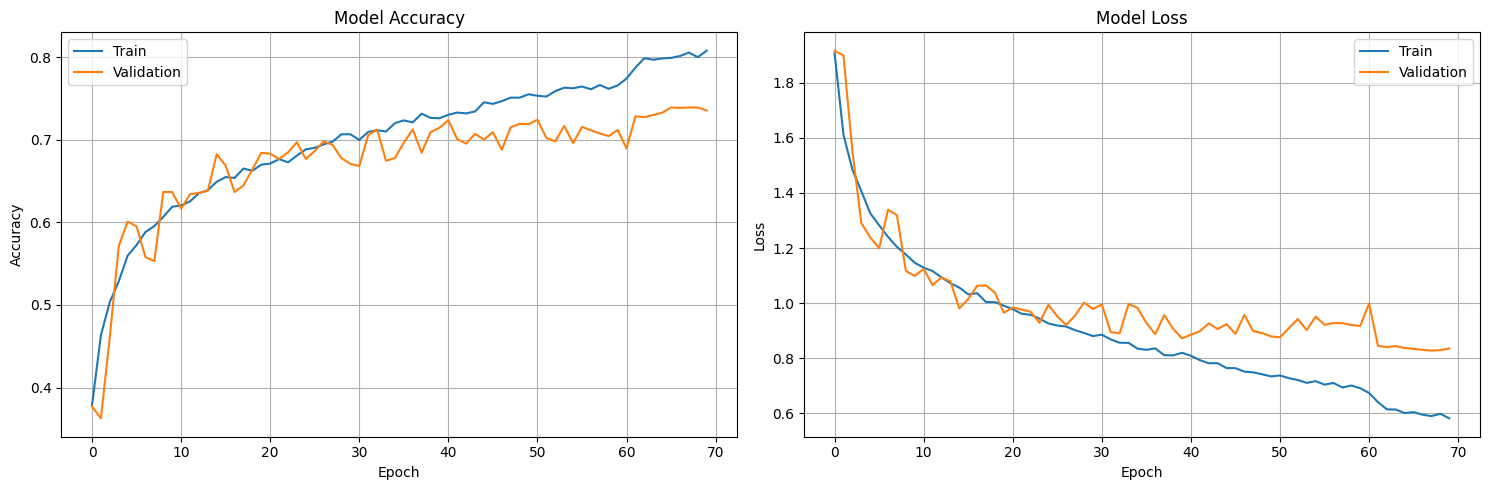

Best validation model: epoch 66  - val_accuracy 0.7391999959945679


In [19]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Model Accuracy ---
ax1.plot(h1.history['accuracy'])
ax1.plot(h1.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# --- Plot 2: Model Loss ---
ax2.plot(h1.history['loss'])
ax2.plot(h1.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()
fig.savefig('training_plots.png')

# --- Your code for printing the best model can go here ---
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

##**1.3. Validation**

In [20]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

    # Save confusion matrix figure
    fig.savefig('confusion_matrix.png')

In [21]:
model.load_weights(MODEL_NAME)
y_true, y_pred = [], []
for ann in val2:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

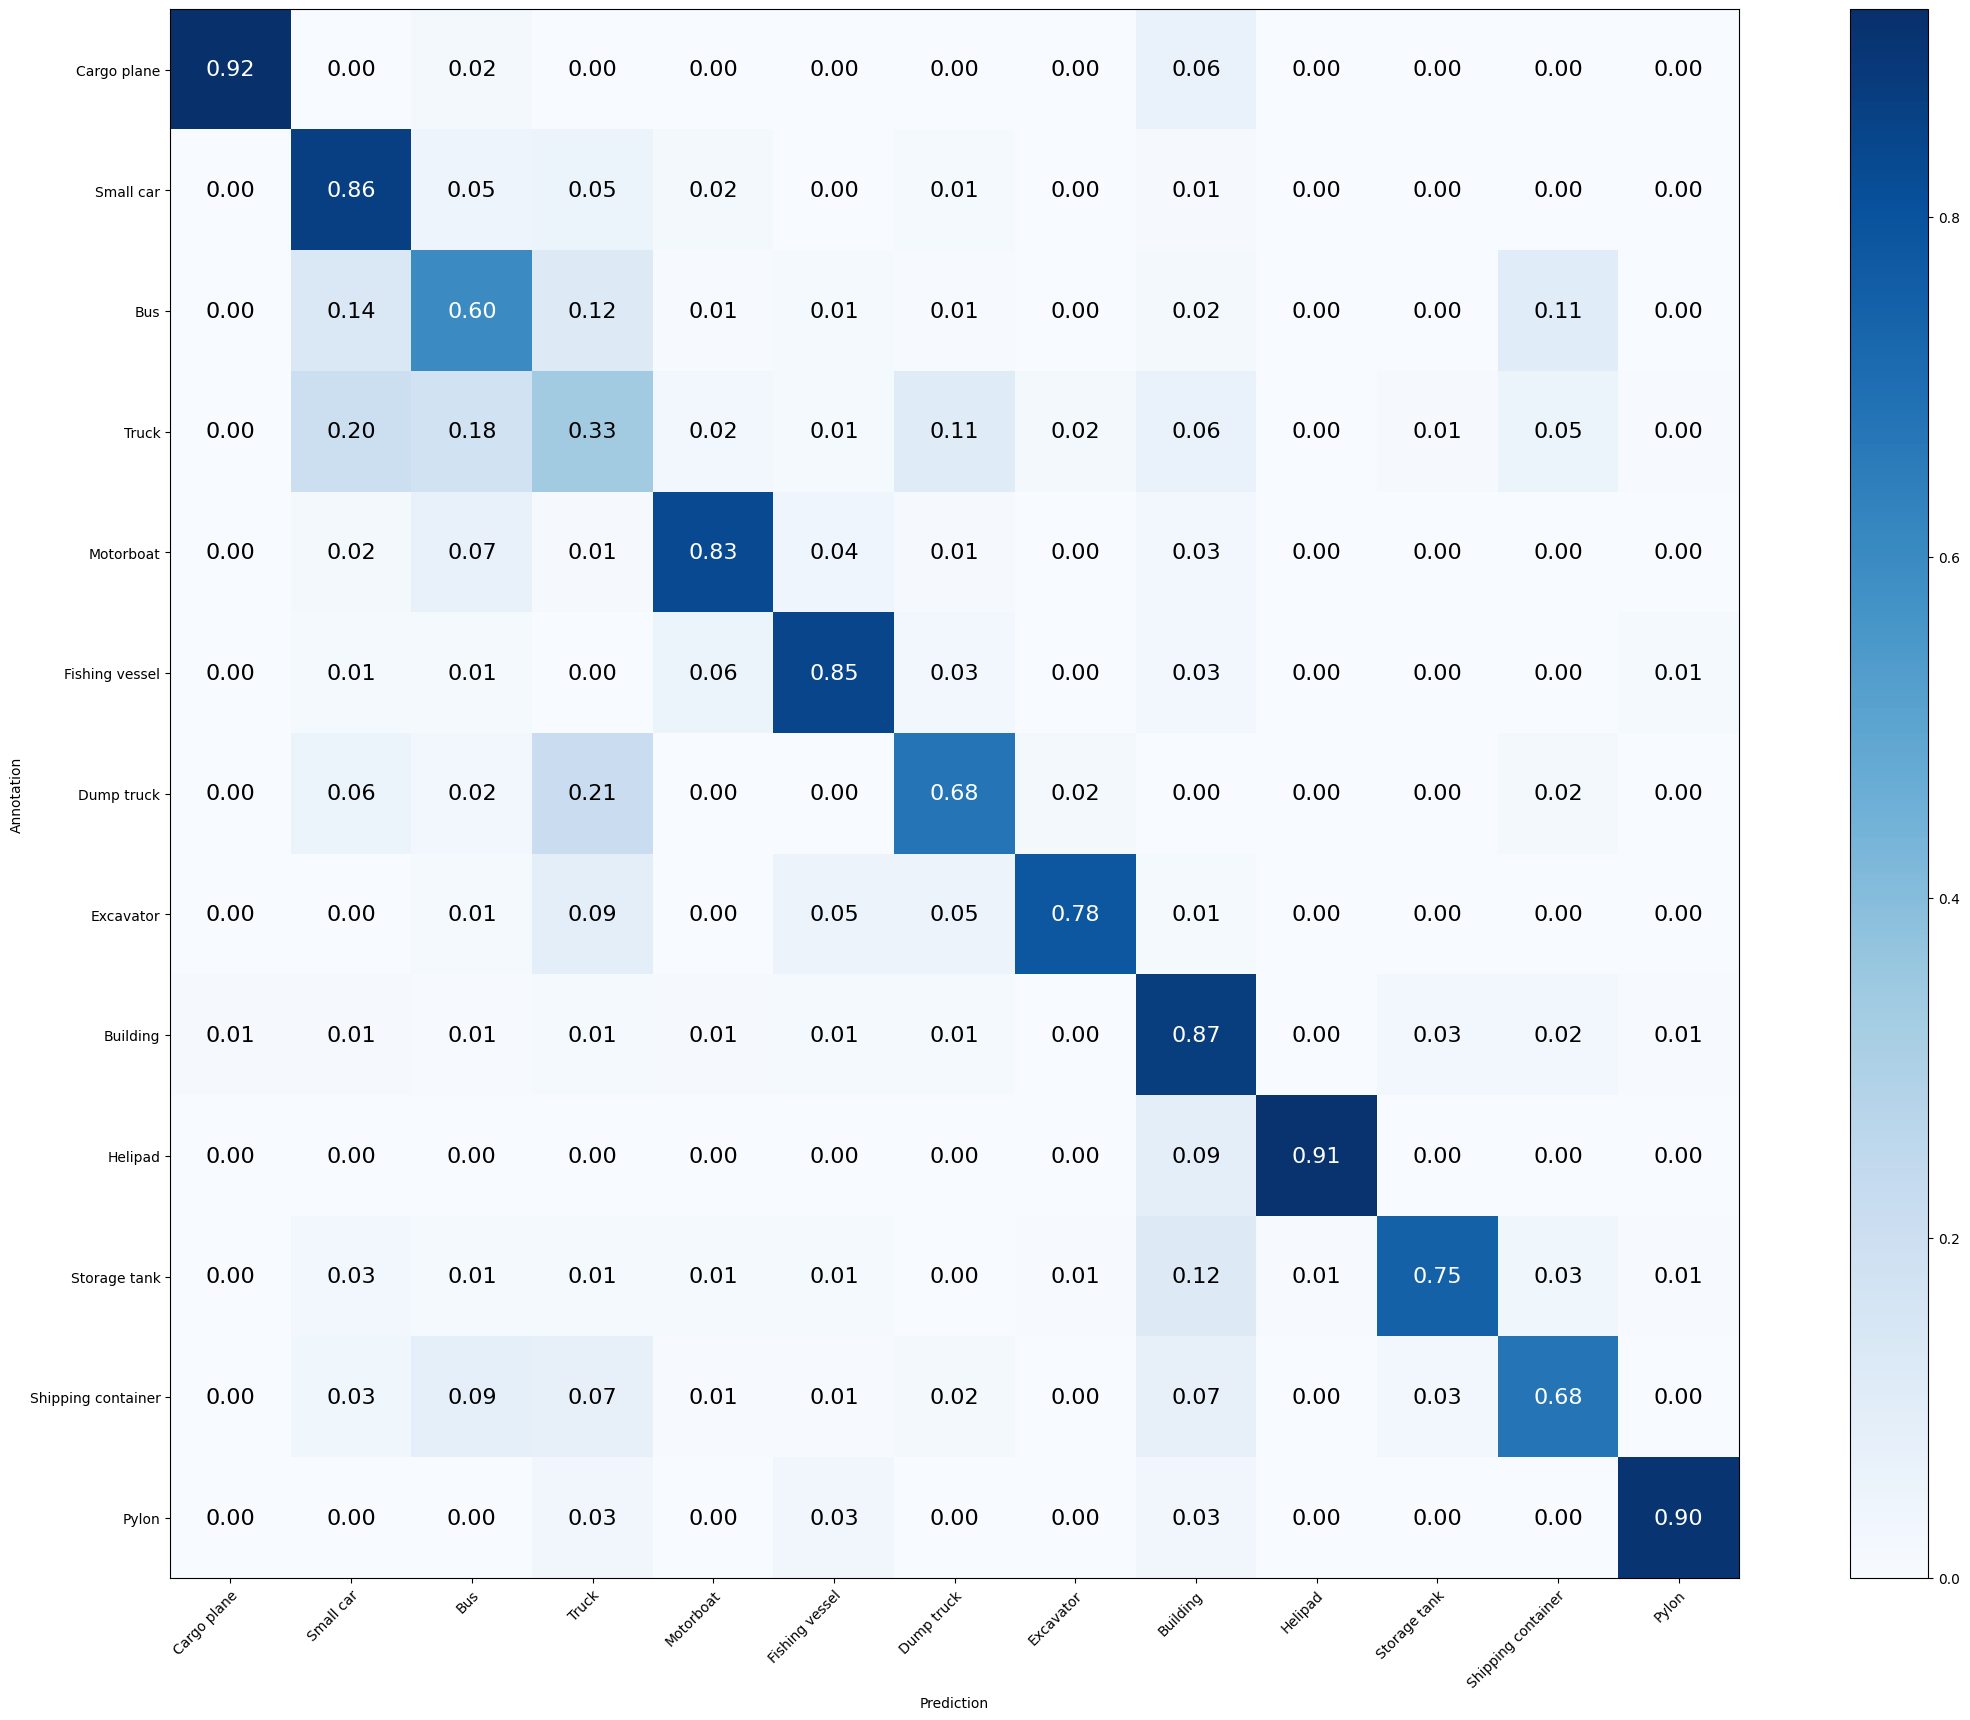

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [23]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))


Mean Accuracy: 73.920%
Mean Recall: 76.708%
Mean Precision: 76.171%
> Cargo plane: Recall: 92.188% Precision: 95.161% Specificity: 99.834% Dice: 93.651%
> Small car: Recall: 86.446% Precision: 76.127% Specificity: 94.167% Dice: 80.959%
> Bus: Recall: 59.887% Precision: 55.789% Specificity: 95.053% Dice: 57.766%
> Truck: Recall: 33.484% Precision: 45.399% Specificity: 94.619% Dice: 38.542%
> Motorboat: Recall: 83.178% Precision: 80.909% Specificity: 98.812% Dice: 82.028%
> Fishing vessel: Recall: 84.507% Precision: 74.074% Specificity: 98.836% Dice: 78.947%
> Dump truck: Recall: 67.742% Precision: 65.625% Specificity: 97.487% Dice: 66.667%
> Excavator: Recall: 78.481% Precision: 88.571% Specificity: 99.555% Dice: 83.221%
> Building: Recall: 87.465% Precision: 83.957% Specificity: 96.042% Dice: 85.675%
> Helipad: Recall: 90.909% Precision: 83.333% Specificity: 99.893% Dice: 86.957%
> Storage tank: Recall: 74.830% Precision: 87.302% Specificity: 99.074% Dice: 80.586%
> Shipping container:

##**1.4 Testing**

In [24]:
anns = []
i = 0
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/xview/xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [25]:
model.load_weights(MODEL_NAME)
predictions_data = {"images": {}, "annotations": {}}

for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage("/".join(ann.filename.split('/')[-3:]))
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [26]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)